In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32').values / 255.0  # Convert DataFrame to numpy array
y = mnist.target.astype('int').values

In [35]:
# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

Epoch 1/20 - Loss: 0.2241 - Test Acc: 0.3609
Epoch 2/20 - Loss: 0.1925 - Test Acc: 0.5962
Epoch 3/20 - Loss: 0.1648 - Test Acc: 0.6989
Epoch 4/20 - Loss: 0.1407 - Test Acc: 0.7511
Epoch 5/20 - Loss: 0.1214 - Test Acc: 0.7796
Epoch 6/20 - Loss: 0.1067 - Test Acc: 0.7996
Epoch 7/20 - Loss: 0.0955 - Test Acc: 0.8117
Epoch 8/20 - Loss: 0.0868 - Test Acc: 0.8229
Epoch 9/20 - Loss: 0.0801 - Test Acc: 0.8325
Epoch 10/20 - Loss: 0.0747 - Test Acc: 0.8398
Epoch 11/20 - Loss: 0.0702 - Test Acc: 0.8450
Epoch 12/20 - Loss: 0.0666 - Test Acc: 0.8491
Epoch 13/20 - Loss: 0.0635 - Test Acc: 0.8536
Epoch 14/20 - Loss: 0.0608 - Test Acc: 0.8572
Epoch 15/20 - Loss: 0.0586 - Test Acc: 0.8610
Epoch 16/20 - Loss: 0.0566 - Test Acc: 0.8642
Epoch 17/20 - Loss: 0.0548 - Test Acc: 0.8666
Epoch 18/20 - Loss: 0.0533 - Test Acc: 0.8687
Epoch 19/20 - Loss: 0.0519 - Test Acc: 0.8717
Epoch 20/20 - Loss: 0.0506 - Test Acc: 0.8733


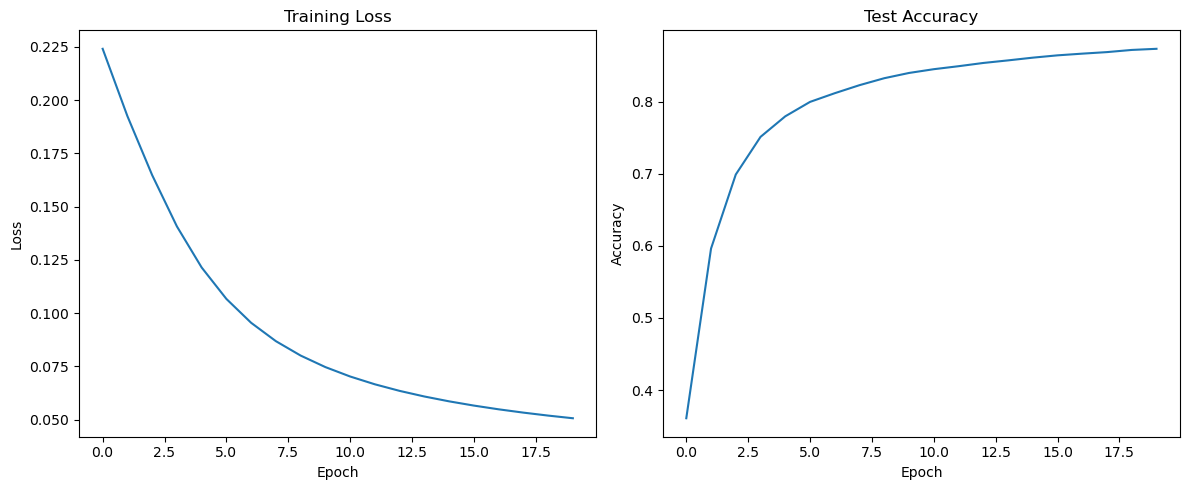

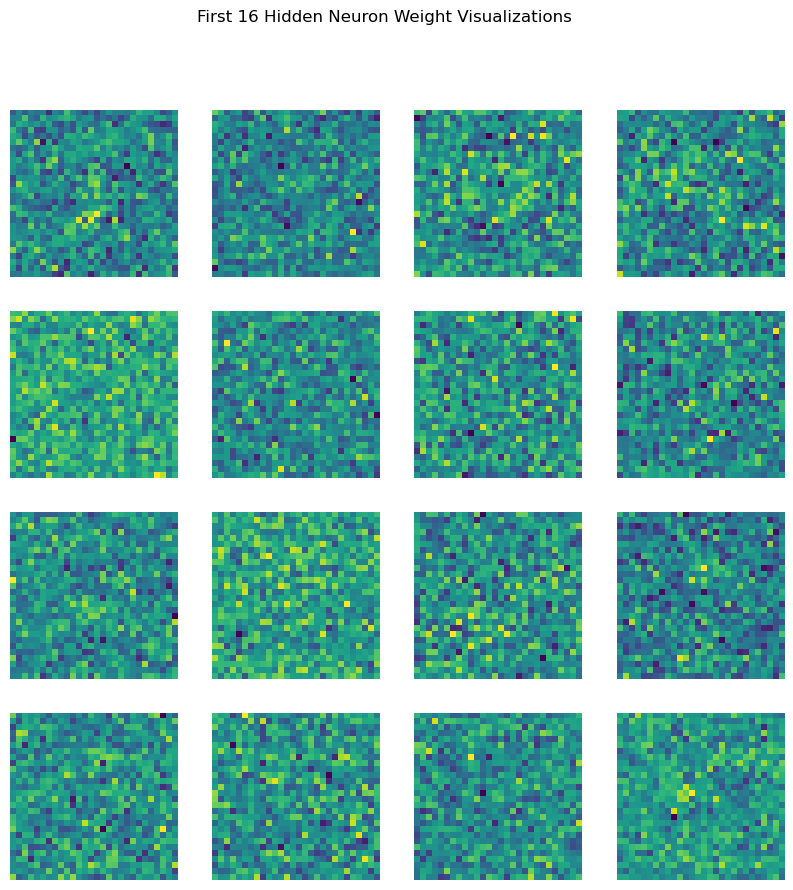

In [36]:
# Neural network parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001  # Reduced learning rate
epochs = 20
batch_size = 128

# Initialize weights
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
b1 = np.zeros(hidden_size)
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
b2 = np.zeros(output_size)

# Activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Training history
train_loss = []
test_acc = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        # Get batch
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        hidden = relu(X_batch @ W1 + b1)
        output = softmax(hidden @ W2 + b2)
        
        # Calculate loss
        loss = -np.mean(y_batch * np.log(output + 1e-10))
        epoch_loss += loss * X_batch.shape[0]
        
        # Backward pass
        d_output = (output - y_batch) / X_batch.shape[0]
        d_W2 = hidden.T @ d_output
        d_b2 = np.sum(d_output, axis=0)
        
        d_hidden = d_output @ W2.T
        d_hidden[hidden <= 0] = 0  # ReLU derivative
        
        d_W1 = X_batch.T @ d_hidden
        d_b1 = np.sum(d_hidden, axis=0)
        
        # Update weights with gradient clipping
        clip_value = 1.0
        W1 -= learning_rate * np.clip(d_W1, -clip_value, clip_value)
        b1 -= learning_rate * np.clip(d_b1, -clip_value, clip_value)
        W2 -= learning_rate * np.clip(d_W2, -clip_value, clip_value)
        b2 -= learning_rate * np.clip(d_b2, -clip_value, clip_value)
    
    # Calculate test accuracy
    test_hidden = relu(X_test @ W1 + b1)
    test_output = softmax(test_hidden @ W2 + b2)
    test_pred = np.argmax(test_output, axis=1)
    accuracy = np.mean(test_pred == np.argmax(y_test, axis=1))
    
    # Store metrics
    train_loss.append(epoch_loss / X_train.shape[0])
    test_acc.append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss[-1]:.4f} - Test Acc: {accuracy:.4f}")

# Visualization functions
def plot_metrics():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(test_acc)
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.tight_layout()
    plt.show()

def visualize_weights():
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(W1[:, i].reshape(28, 28), cmap='viridis')
        plt.axis('off')
    plt.suptitle("First 16 Hidden Neuron Weight Visualizations")
    plt.show()

# Run visualizations
plot_metrics()
visualize_weights()

In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Configuration
GRID_SIZE = 32          # 32x32 grid (1024 cells)
INPUT_SIZE = 784        # MNIST pixels
OUTPUT_SIZE = 10        # Digit classes
TIME_STEPS = 30         # Simulation steps
ALPHA = 0.08            # Decay rate
BETA = 0.4              # Flow strength

class PhlogistonSystem(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create input mapping (1 pixel -> 1 cell)
        self.input_cells = [(i//28 + 2, i%28 + 2) for i in range(784)]  # Centered on 32x32 grid
        
        # Fixed output collector positions
        self.output_cells = [(4,16), (8,8), (8,24), (12,16), (16,8), 
                            (16,24), (20,16), (24,8), (24,24), (28,16)]
        
        # Learnable parameters
        self.thresholds = nn.Parameter(torch.rand(GRID_SIZE, GRID_SIZE, 8)*0.3)  # Flow thresholds
        self.output_weights = nn.Parameter(torch.ones(10))  # Collector sensitivity

    def forward(self, x):
        # Initialize grid state
        grid = torch.zeros(GRID_SIZE, GRID_SIZE)
        
        # Apply input stimuli
        pixel_values = x.view(-1)
        for idx, (i,j) in enumerate(self.input_cells):
            grid[i,j] = pixel_values[idx]  # Direct stimulus injection
            
        # Define neighbor directions (8-connected)
        neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), 
                    (0,1), (1,-1), (1,0), (1,1)]
        
        # Simulate phlogiston flow
        for _ in range(TIME_STEPS):
            delta = torch.zeros_like(grid)
            
            # Calculate flow for each cell
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    current = grid[i,j]
                    
                    # Natural decay
                    delta[i,j] -= ALPHA * current
                    
                    # Flow to neighbors
                    for dir_idx, (di, dj) in enumerate(neighbors):
                        ni, nj = i+di, j+dj
                        if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
                            threshold = self.thresholds[i,j,dir_idx]
                            flow = torch.sigmoid(5*(current - threshold)) * BETA
                            delta[i,j] -= flow
                            delta[ni,nj] += flow
                            
            grid += delta
            
        # Read output collectors
        outputs = torch.zeros(10)
        for idx, (i,j) in enumerate(self.output_cells):
            outputs[idx] = grid[i,j].sigmoid() * self.output_weights[idx]
            
        return torch.softmax(outputs, dim=0)

# Initialize system
model = PhlogistonSystem()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X = torch.tensor(mnist.data.values.astype('float32')/255)
y = torch.tensor(mnist.target.astype('int').values)

# Training loop
for epoch in range(15):
    total_loss = 0
    for i in range(1000):  # Reduced dataset
        optimizer.zero_grad()
        output = model(X[i])
        loss = criterion(output.unsqueeze(0), y[i].unsqueeze(0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Loss: {total_loss/1000:.4f}")

# Visualization
def visualize_phlogiston(sample):
    model.eval()
    with torch.no_grad():
        grid = torch.zeros(GRID_SIZE, GRID_SIZE)
        pixel_values = sample.view(-1)
        
        # Apply inputs
        for idx, (i,j) in enumerate(model.input_cells):
            grid[i,j] = pixel_values[idx]
            
        # Create figure
        fig, ax = plt.subplots(1, 2, figsize=(12,6))
        
        # Original image
        ax[0].imshow(sample.view(28,28), cmap='gray')
        ax[0].set_title('Input Digit')
        
        # Phlogiston grid
        for _ in range(TIME_STEPS):
            delta = torch.zeros_like(grid)
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    current = grid[i,j]
                    delta[i,j] -= ALPHA * current
                    for dir_idx, (di, dj) in enumerate(neighbors):
                        ni, nj = i+di, j+dj
                        if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
                            threshold = model.thresholds[i,j,dir_idx].item()
                            flow = (current > threshold) * BETA
                            delta[i,j] -= flow
                            delta[ni,nj] += flow
            grid += delta
            
        # Mark collectors
        display_grid = grid.numpy()
        for idx, (i,j) in enumerate(model.output_cells):
            display_grid[i,j] = 2.0  # Highlight collectors
            
        ax[1].imshow

RuntimeError: expected scalar type Long but found Int